In [98]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [6]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Define

In [7]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Những segment có F1 > 0.5 thì coi như detect được

In [8]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,anomaly_idx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    anomaly = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    anomaly[anomaly_idx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(anomaly, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(anomaly, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(anomaly, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(anomaly, pred))
    
    accuracy = (tp + tn) / len(anomaly)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    result ={'Metrics':['Accuracy' ,'Precision','Recall','F1-score' ],
             'Score':[accuracy,precision, recall, f1]}
    result = pd.DataFrame(result)
    display(result.T)
    return accuracy,precision,recall,f1

# Data

In [9]:
num_datapoints = 8640
time_index = pd.date_range(start='2024-01-01', periods=num_datapoints, freq='s')

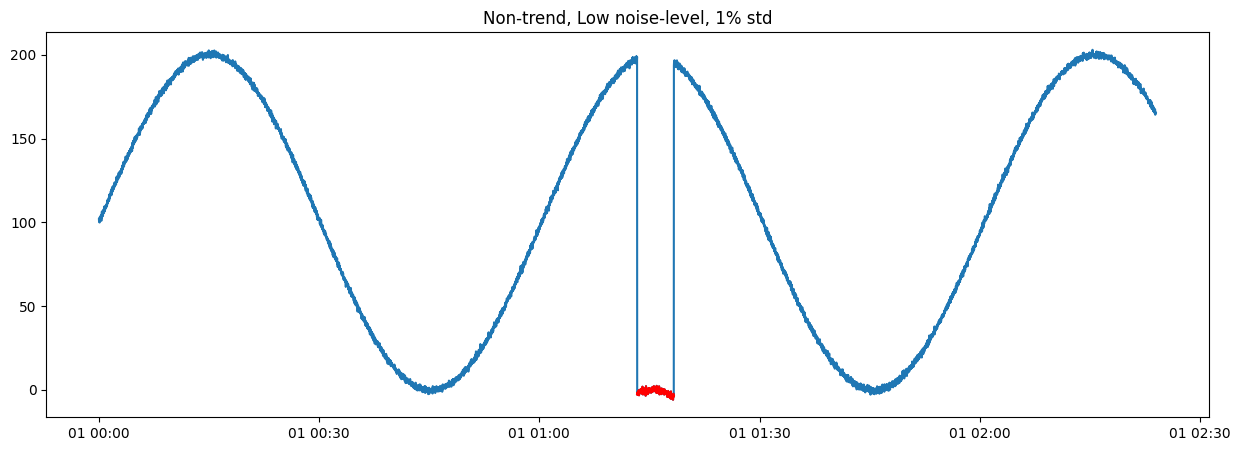

In [99]:
mean_traffic = 100  
std_dev_traffic = 1

start_noise_period = 4400  
end_noise_period = 4700   
noise_level = 200


noise = np.zeros(num_datapoints)
noise[start_noise_period:end_noise_period] = np.full(300,noise_level)

traffic_data = np.random.normal(loc=mean_traffic, scale=std_dev_traffic, size=num_datapoints)
traffic_data_with_noise = traffic_data - noise
traffic_data_with_noise = traffic_data_with_noise + np.sin(np.arange(num_datapoints)*15/num_datapoints)*100

network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data_with_noise},index=time_index)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(network_traffic_df)
ax.plot(network_traffic_df[start_noise_period:end_noise_period],c='r')
ax.set_title('Non-trend, Low noise-level, 1% std');

In [11]:
anomaly_idx = list(np.arange(start_noise_period,end_noise_period))

# Feature

In [12]:
ts = pd.DataFrame(network_traffic_df['Traffic_Mbps'])
ts['id'] = 1

In [13]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_value='Traffic_Mbps')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.92s/it]


In [14]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=['Traffic_Mbps__mean',
                                                                     'Traffic_Mbps__median',
                                                                     'Traffic_Mbps__variance',
                                                                     'Traffic_Mbps__standard_deviation',
                                                                     'Traffic_Mbps__absolute_sum_of_changes',
                                                                     'Traffic_Mbps__mean_abs_change',
                                                                     'Traffic_Mbps__kurtosis',
                                                                     'Traffic_Mbps__minimum',
                                                                     'Traffic_Mbps__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: 'Traffic_Mbps'})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','absolute_sum_of_changes','mean_abs_change',
                                      'kurtosis','minimum','maximum']

In [15]:
extracted_relevant_feature

,Traffic_Mbps
mean,104.766749
median,113.999449
variance,5159.711223
standard_deviation,71.831130
absolute_sum_of_changes,10003.014053
mean_abs_change,1.157890
kurtosis,-1.502673
minimum,-5.871039
maximum,202.953165


# Top-down

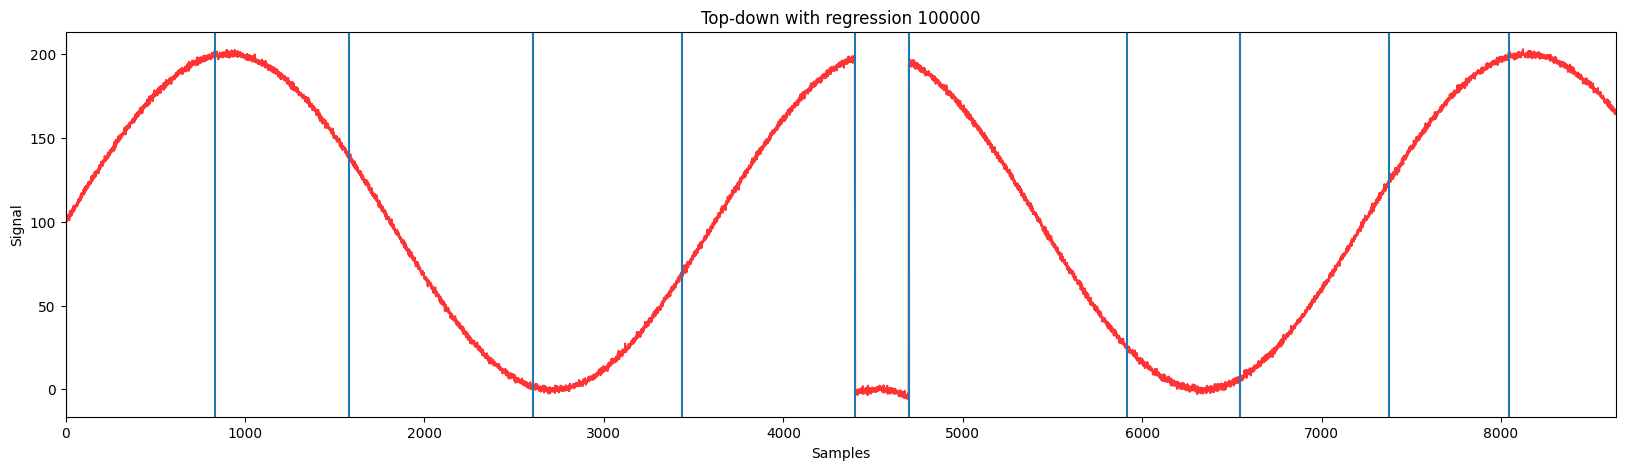

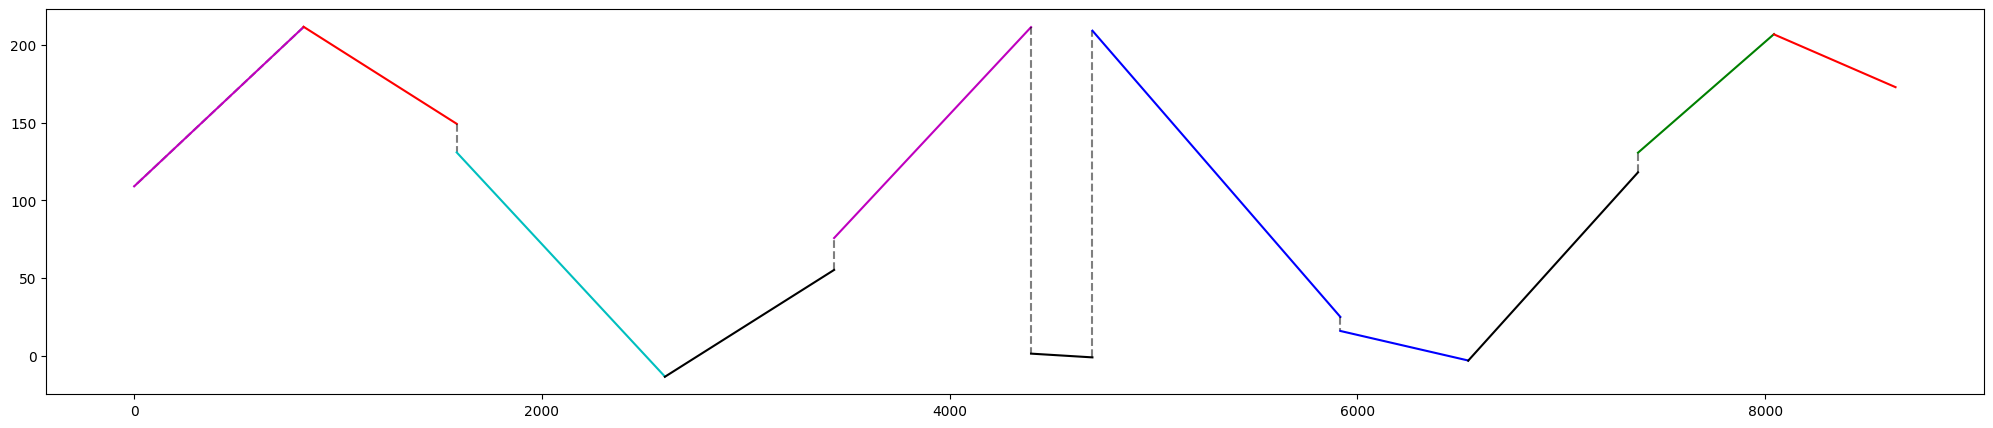

In [17]:
max_error = 100000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

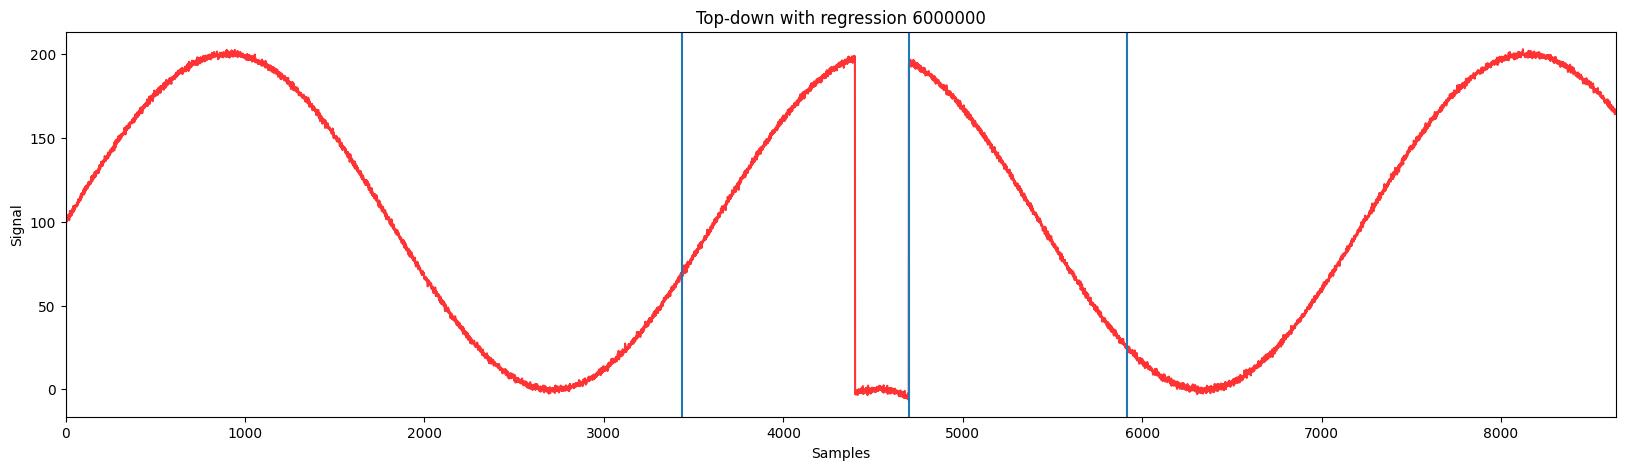

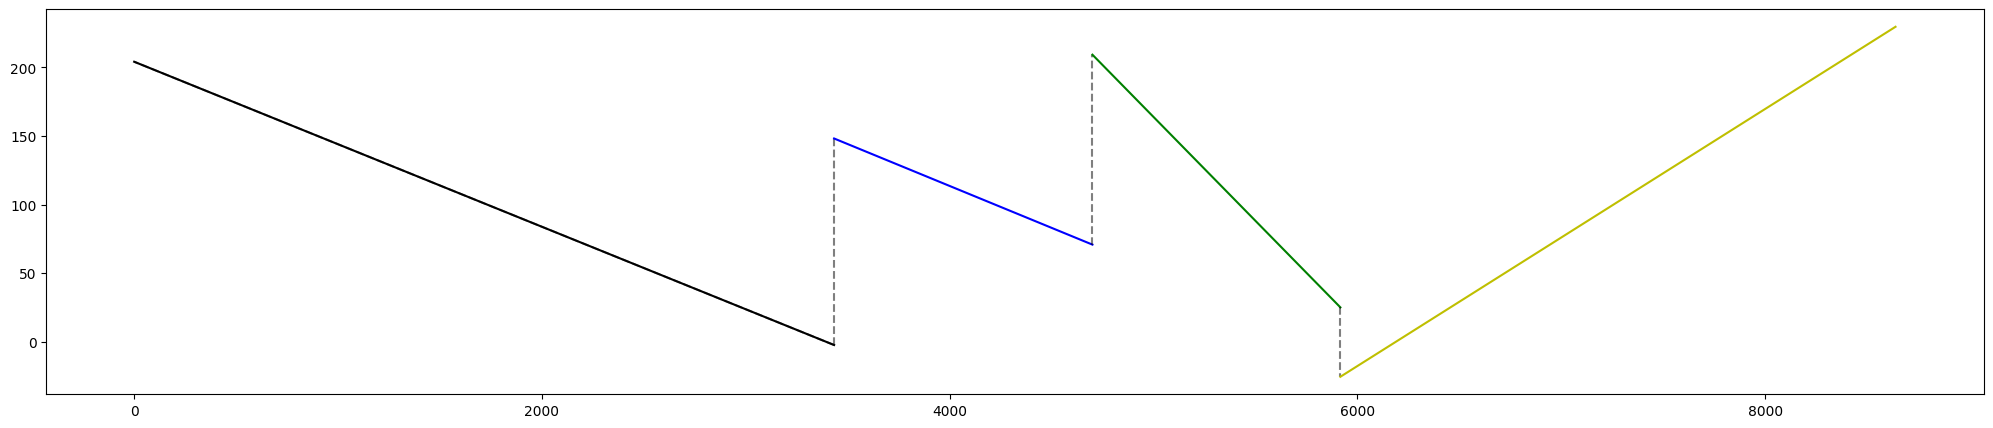

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.824537,0.0,0.0,0.0


In [26]:
max_error = 6000000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

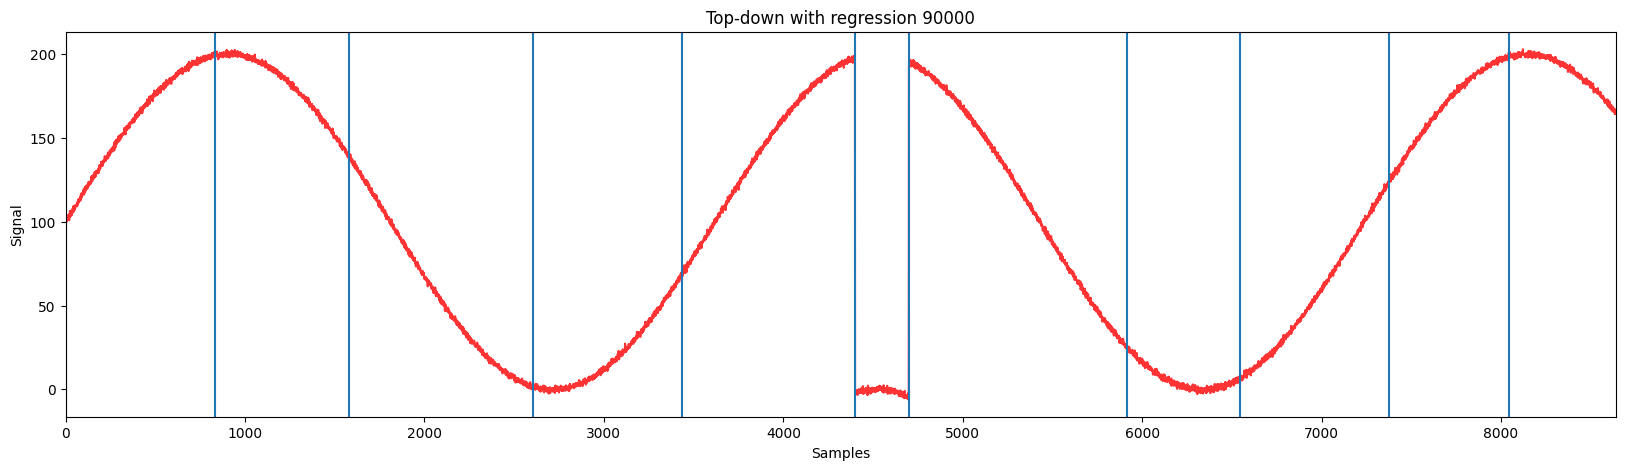

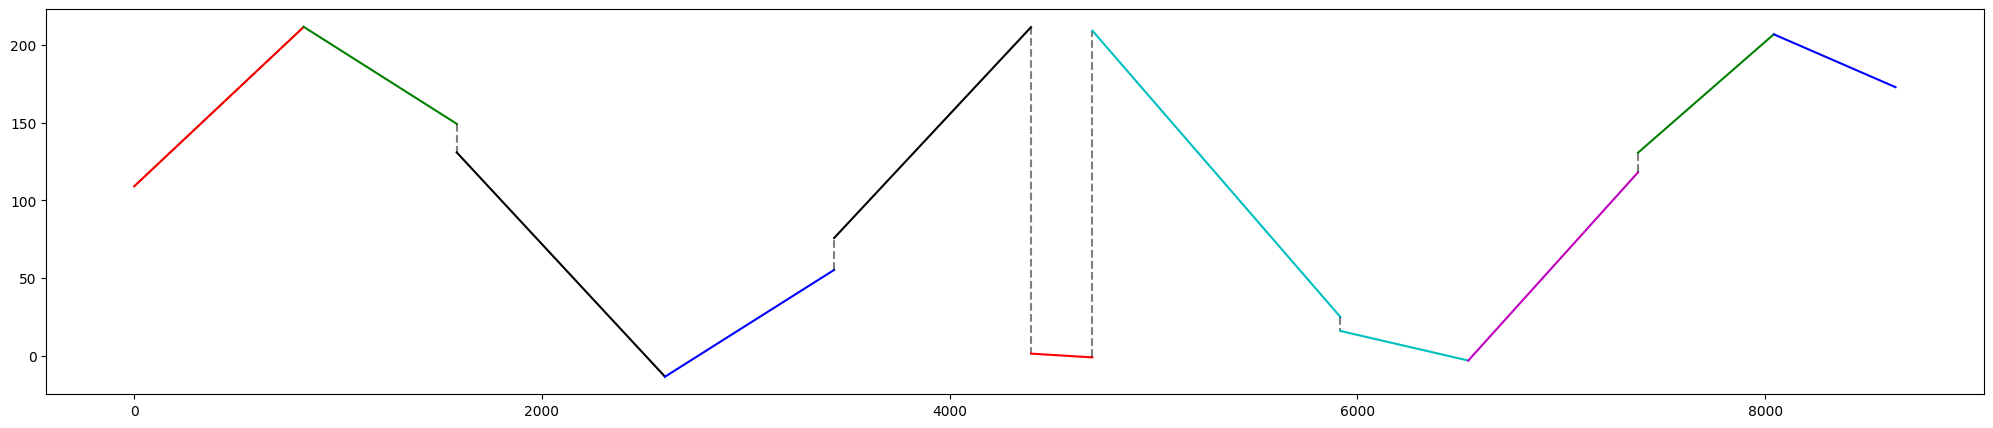

In [30]:
max_error = 90000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [34]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999884,0.996678,1.0,0.998336


In [33]:
range_max_error_topdown = (90000,5000000)
best_Top_down = 2500000
time_avg_Top_down = (26.2+18.1+23.9)/3

# Bottom-up

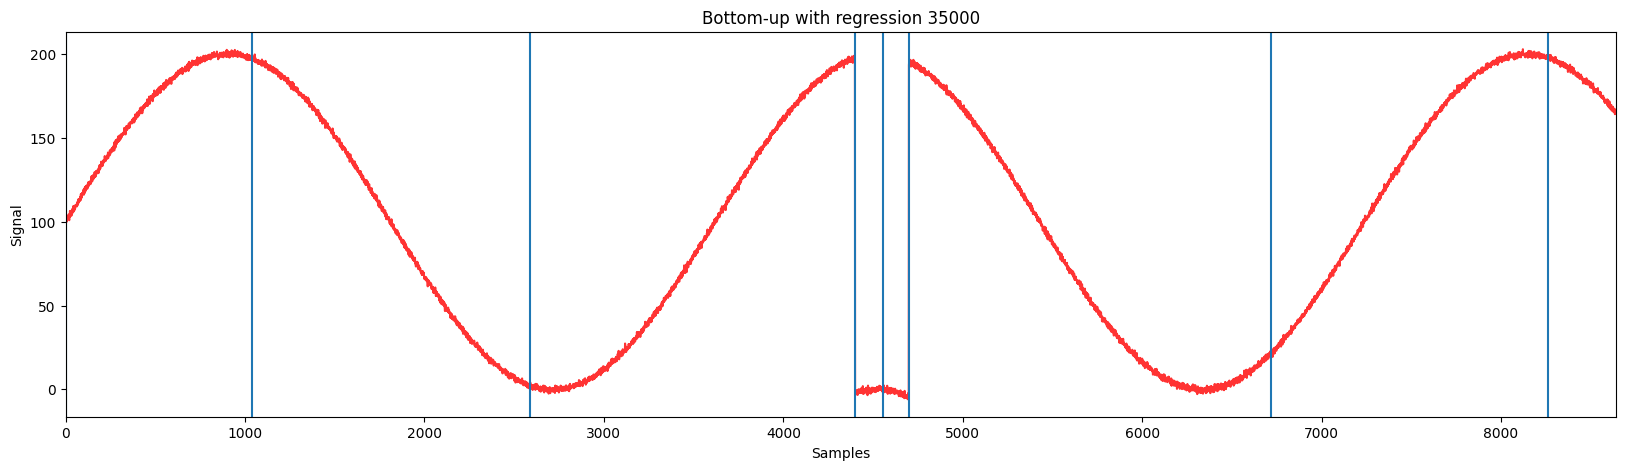

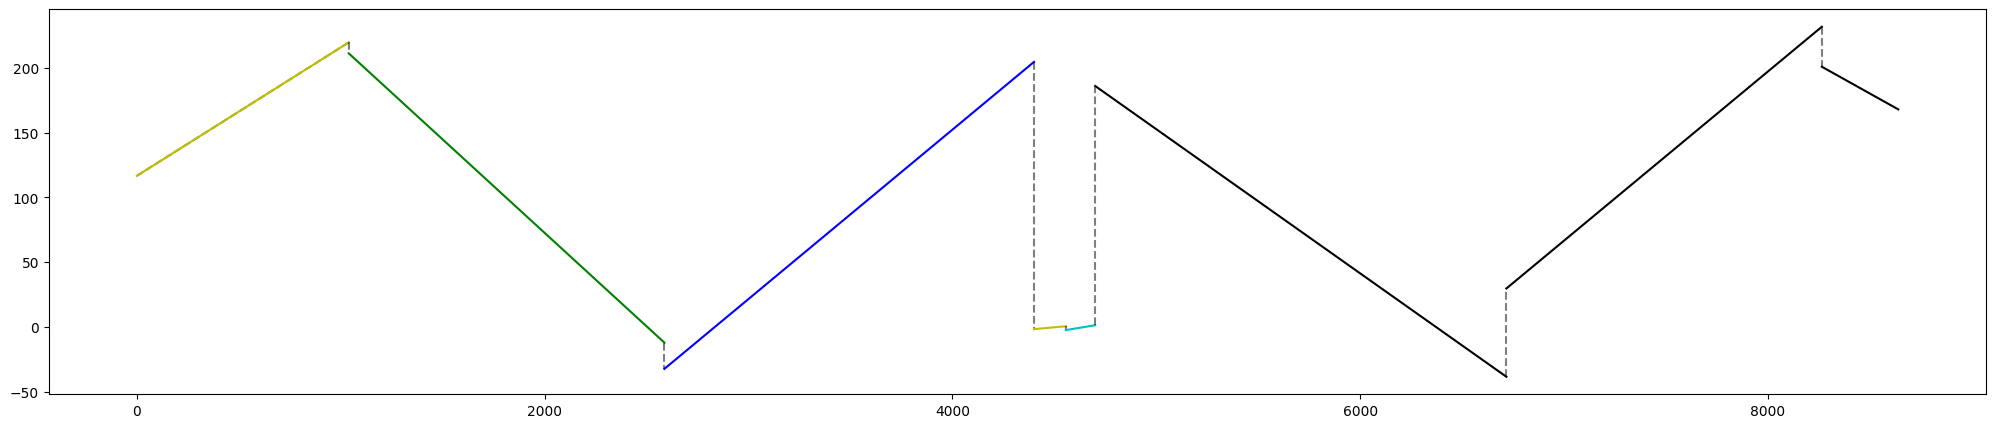

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.983333,1.0,0.52,0.684211


In [44]:
max_error = 35000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

## Best

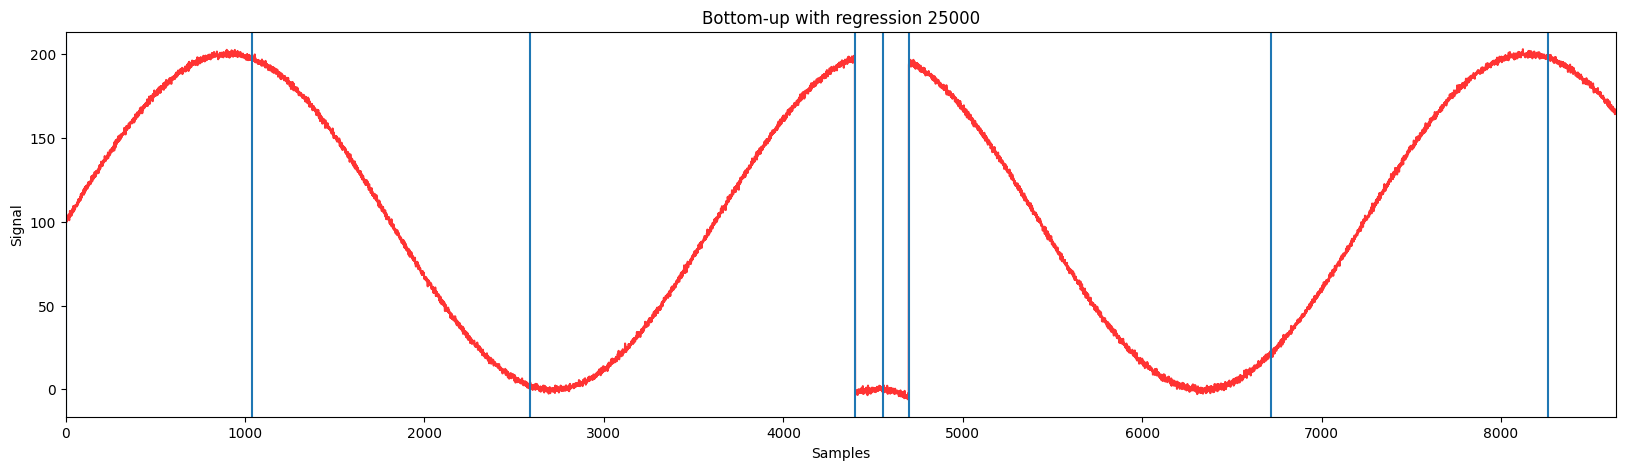

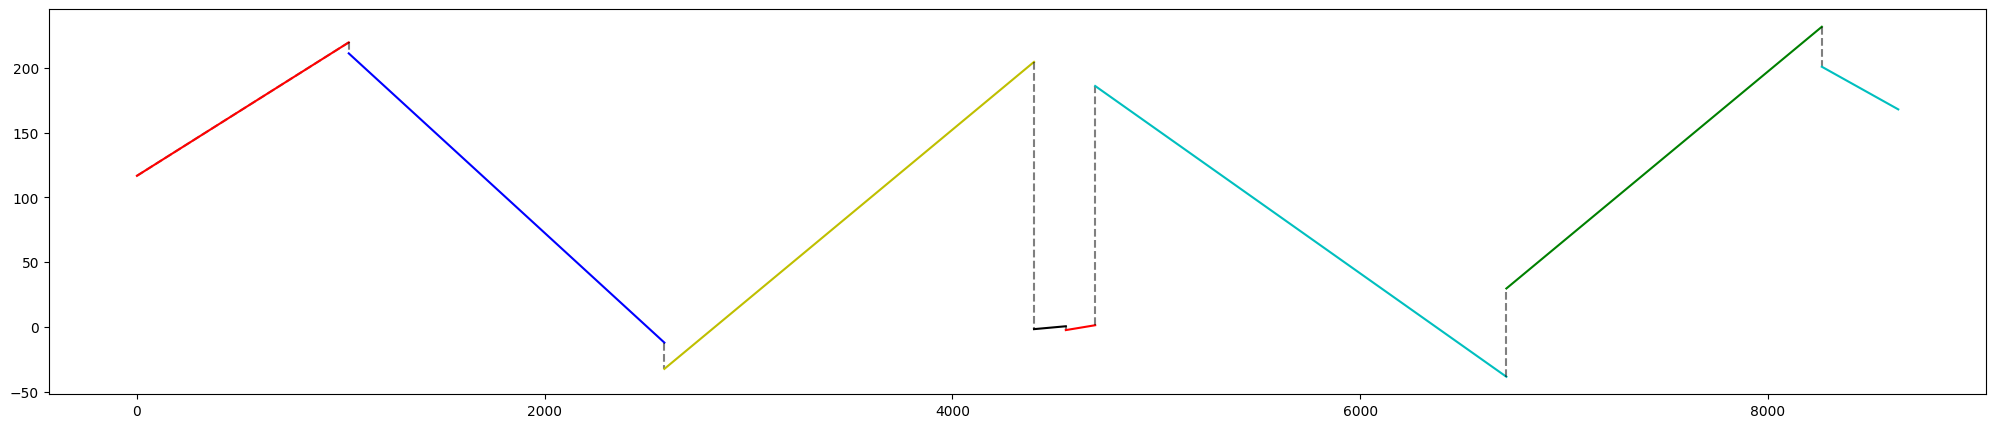

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.983333,1.0,0.52,0.684211


In [77]:
max_error = 25000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

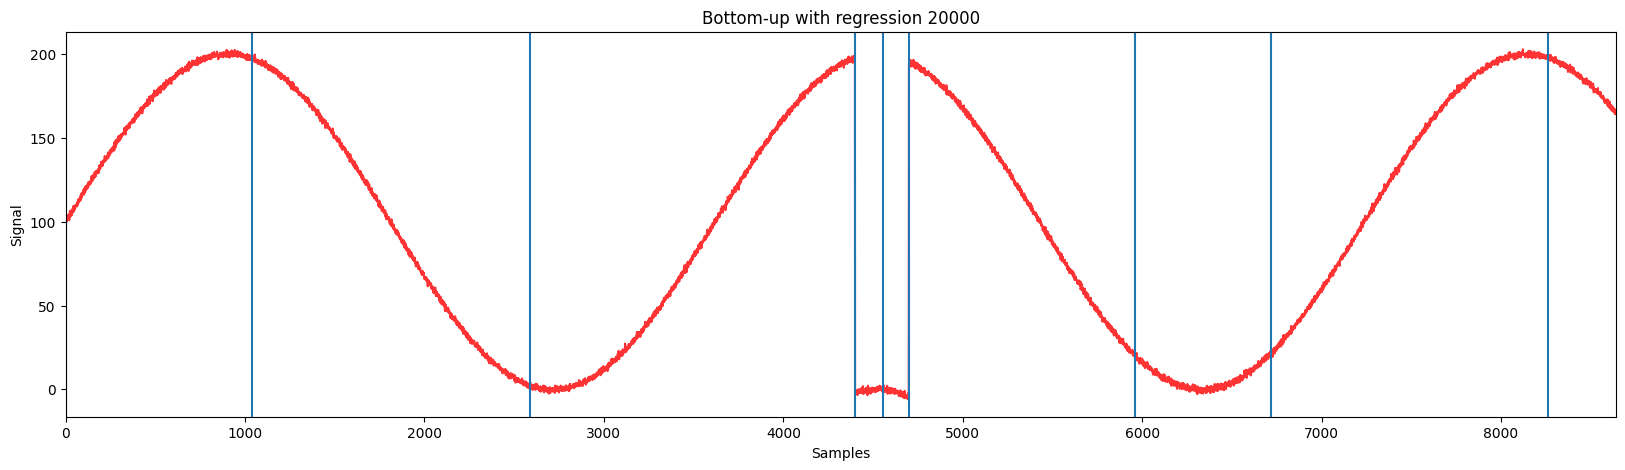

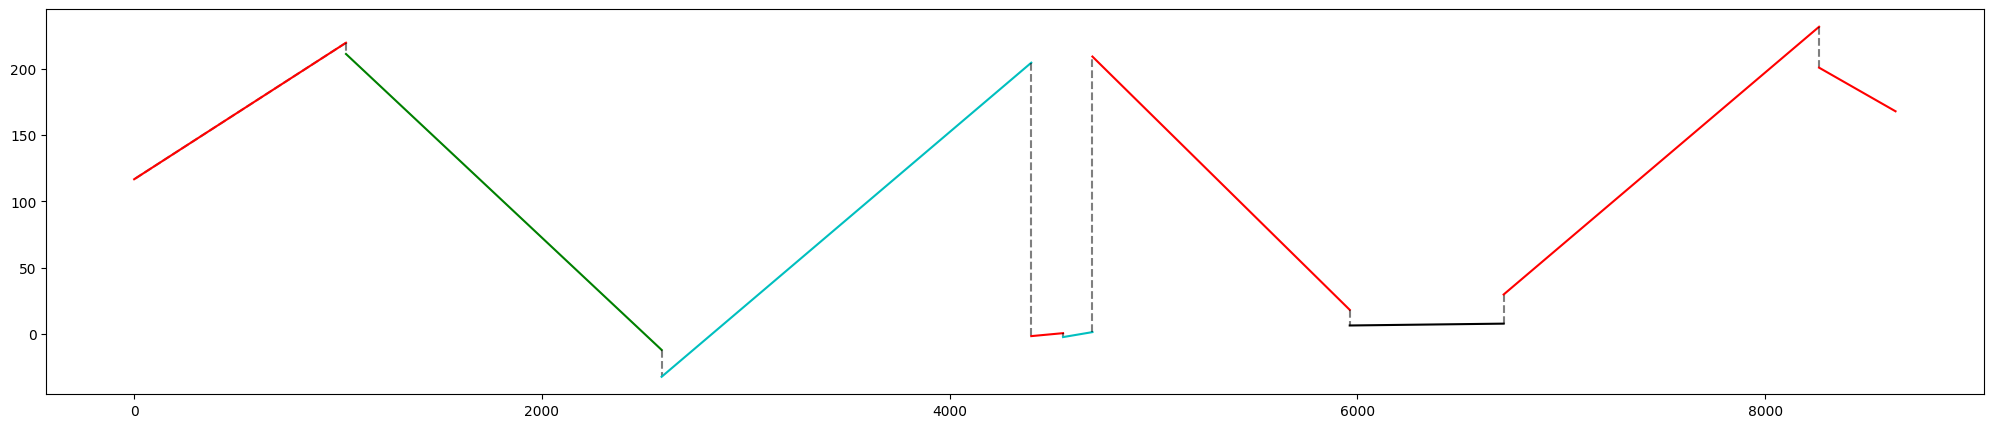

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.819213,0.0,0.0,0.0


In [45]:
max_error = 20000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [46]:
range_max_error_bottomup = (25000,35000)
best_Bottom_up = 30000
time_avg_Bottom_up = (5.40+5.49+5.52)/3

# Sliding window

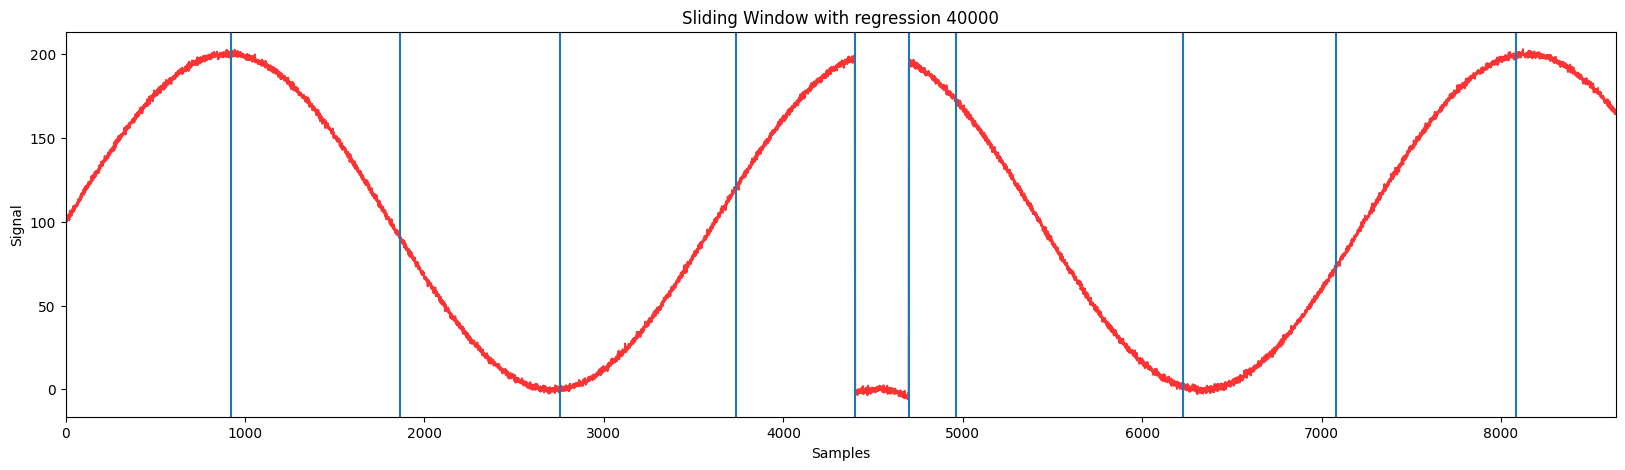

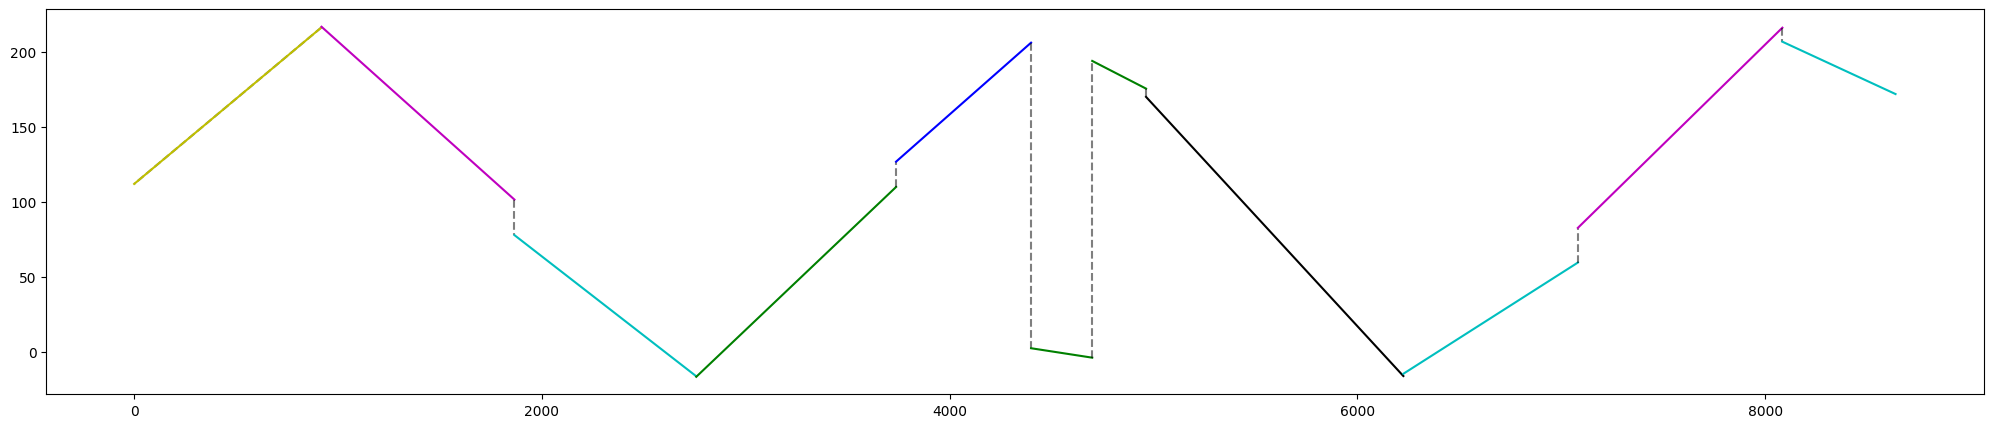

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999769,0.996667,0.996667,0.996667


In [56]:
max_error = 40000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

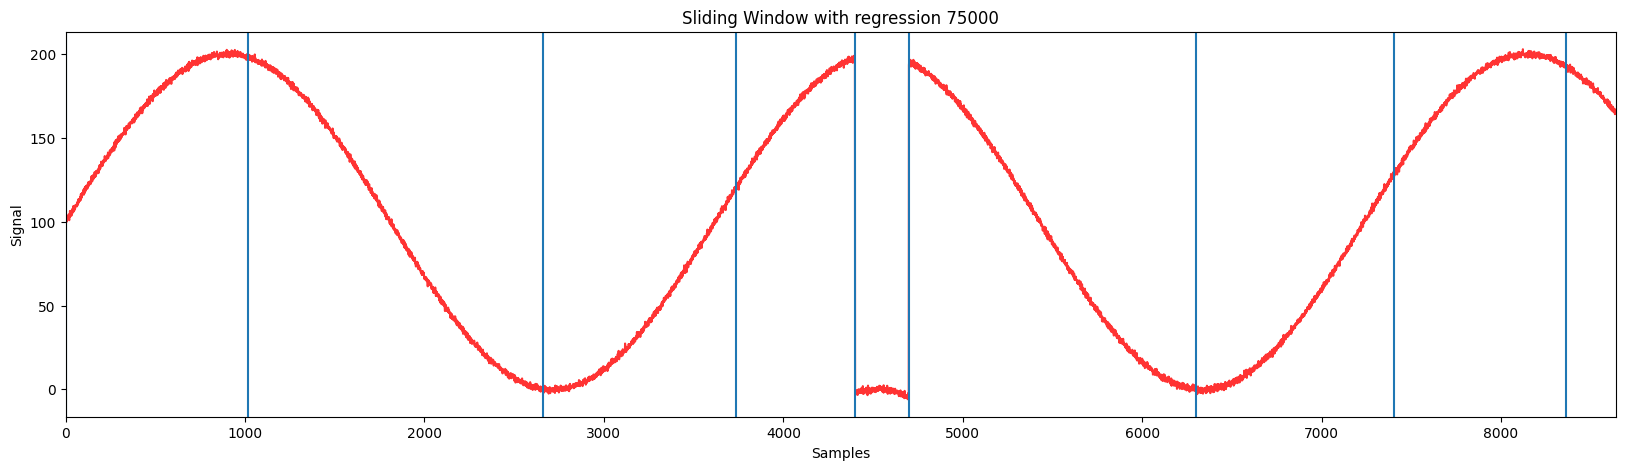

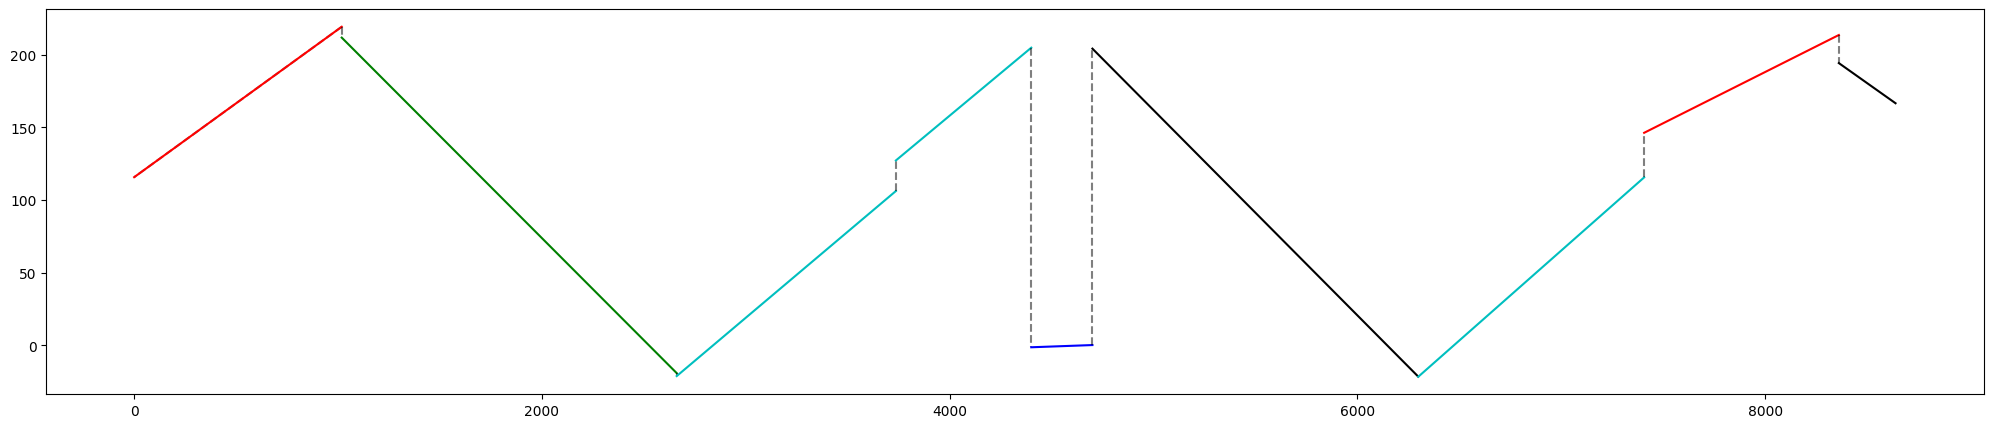

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [76]:
max_error = 75000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

## Best

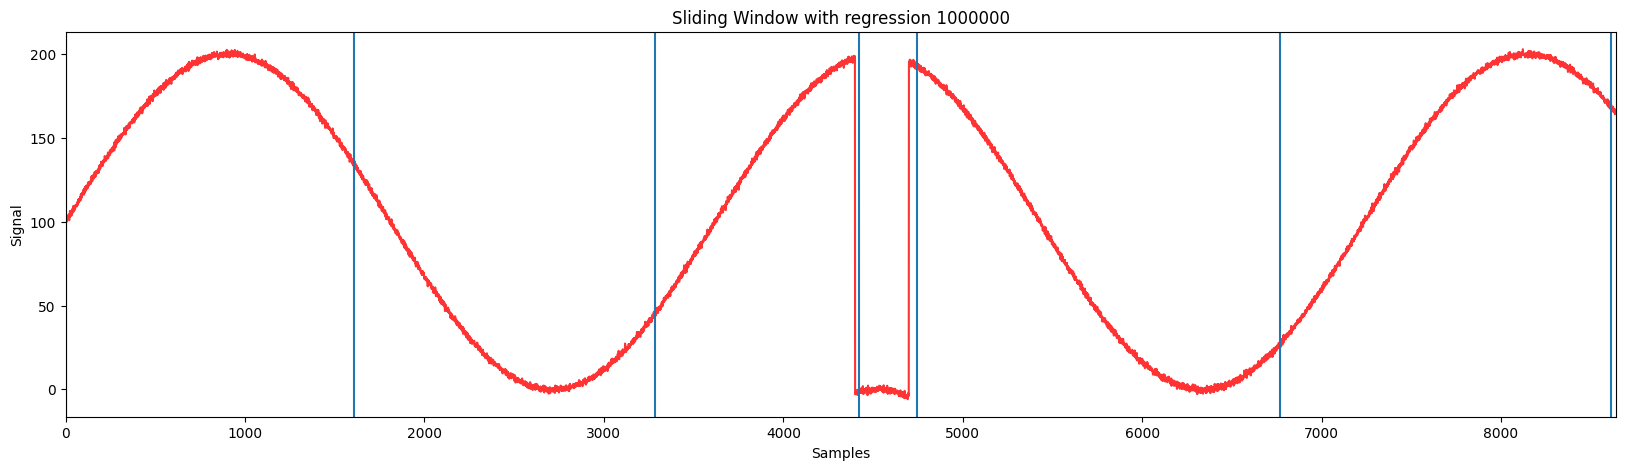

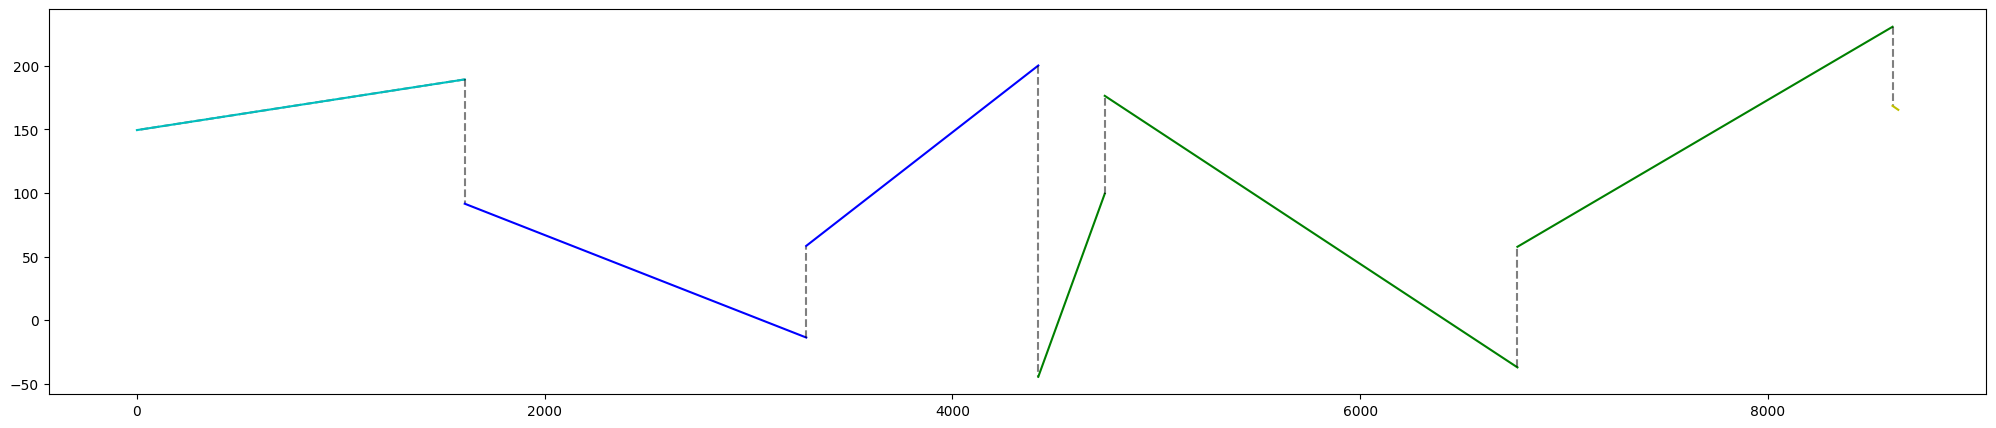

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.99213,0.855828,0.93,0.891374


In [66]:
max_error = 1000000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [74]:
range_max_error_sldw = (40000,1000000)
best_sliding_window = 75000
time_avg_sliding_window = (2.04+1.93+1.68)/3

# SWAB

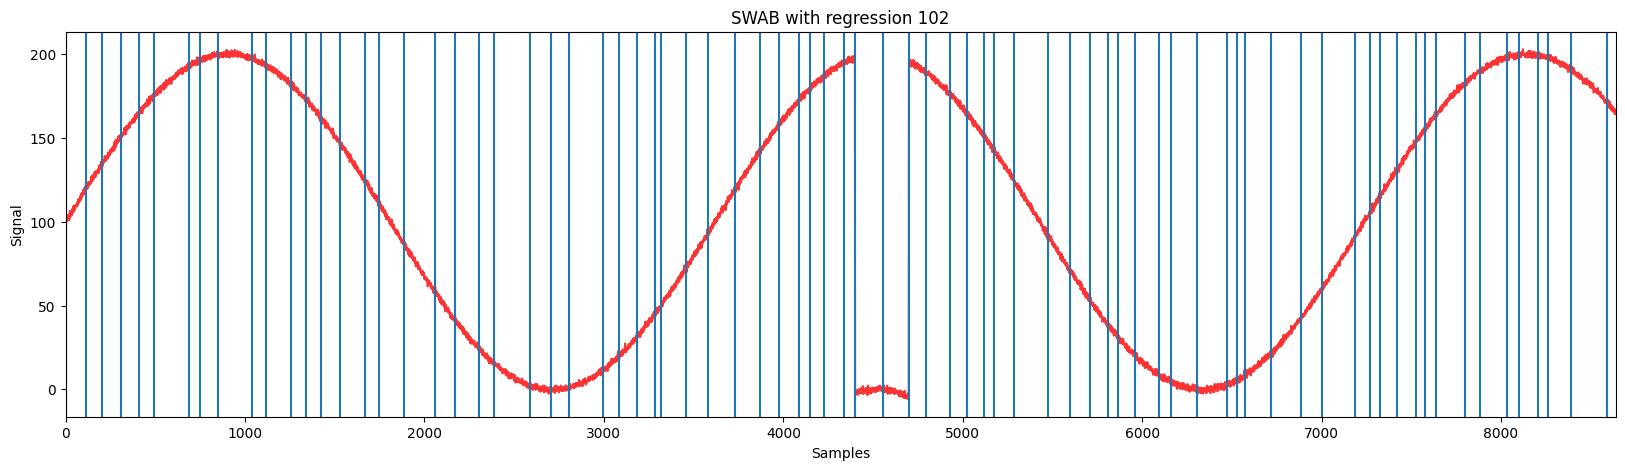

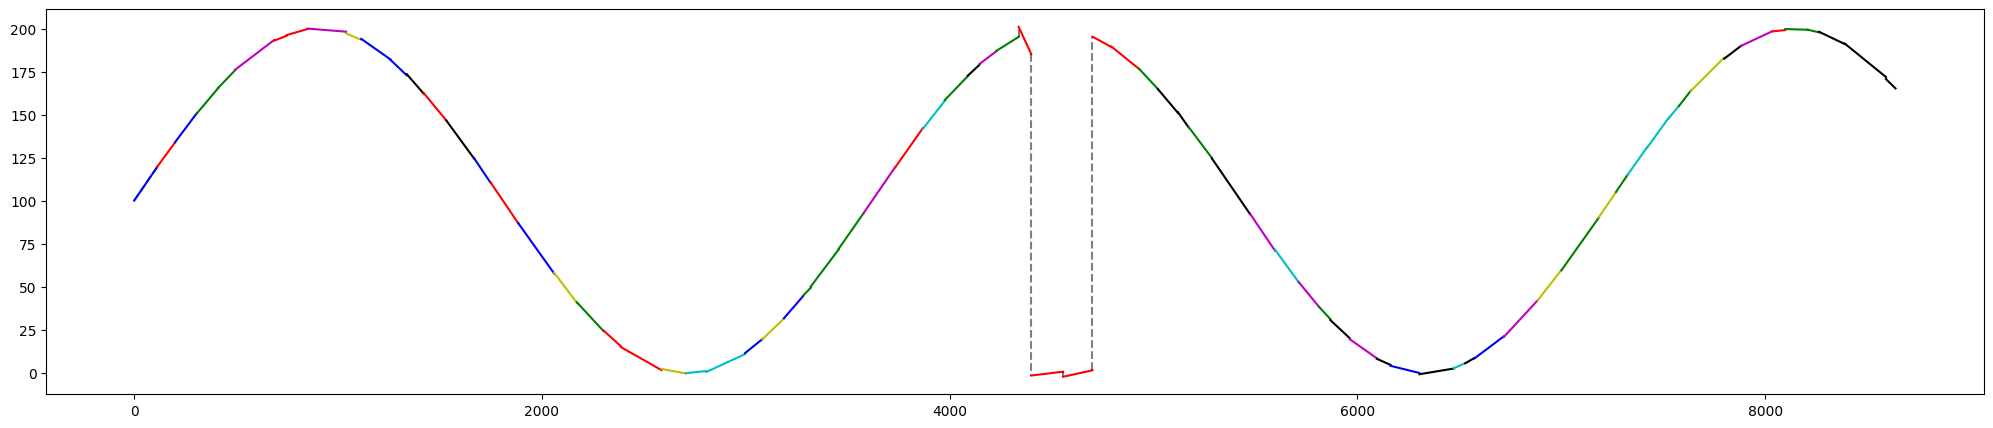

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.981944,1.0,0.48,0.648649


In [109]:
max_error = 102
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

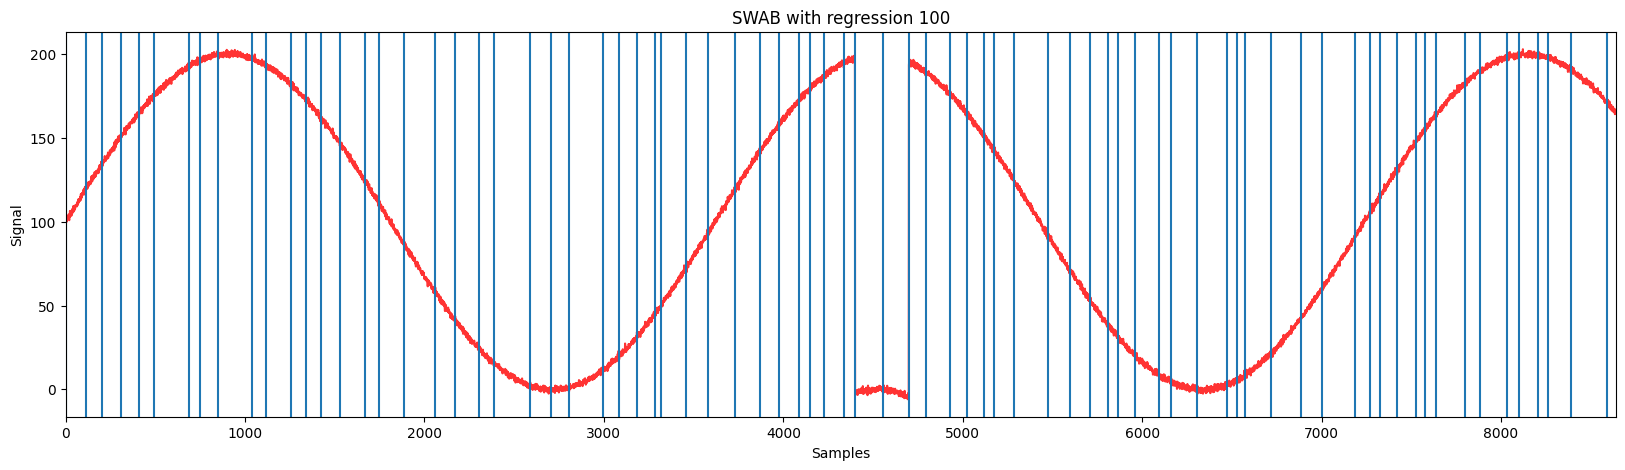

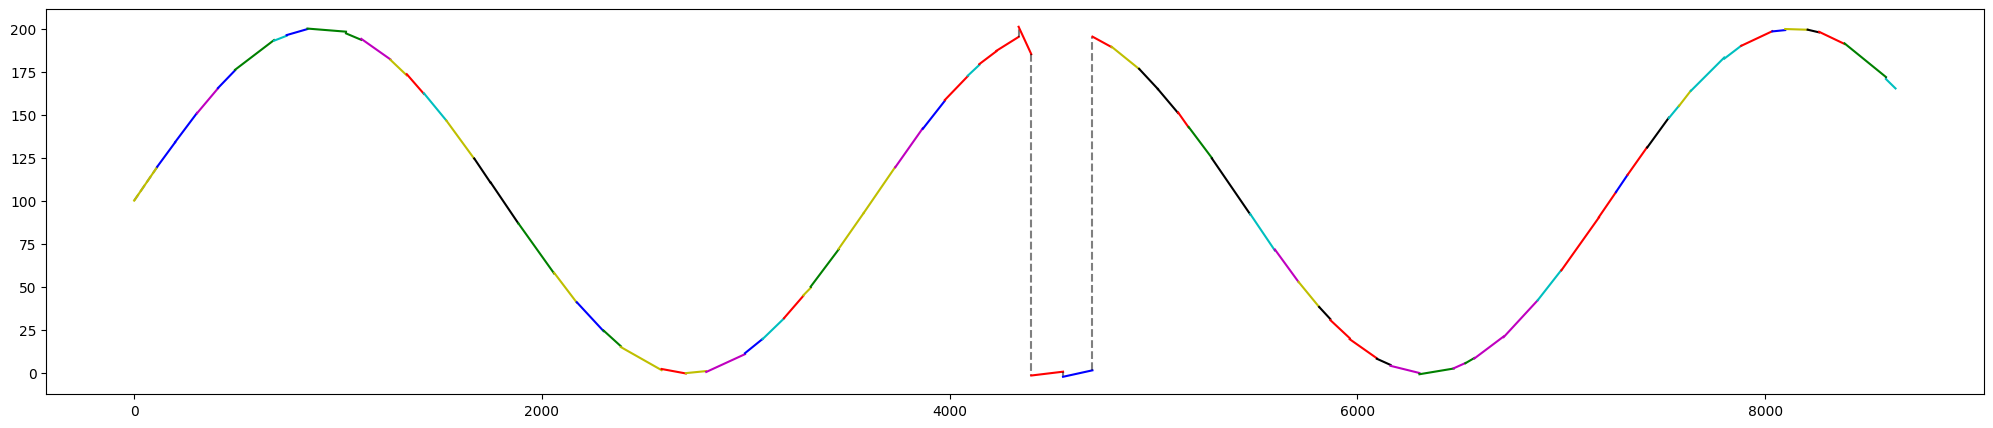

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.981944,1.0,0.48,0.648649


In [100]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

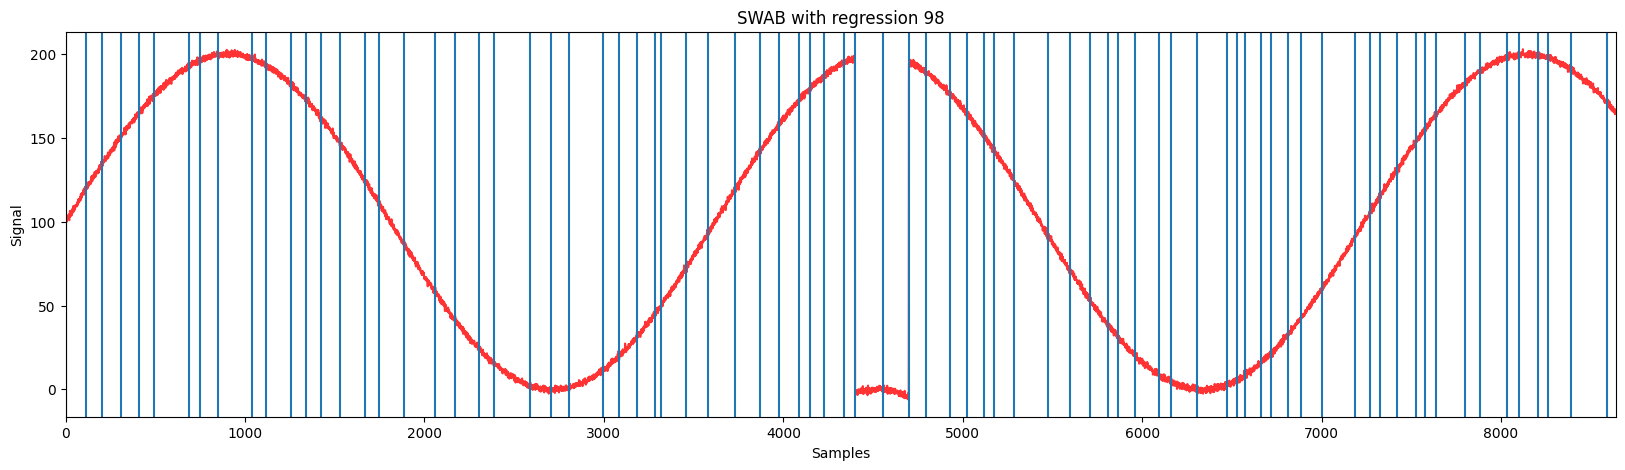

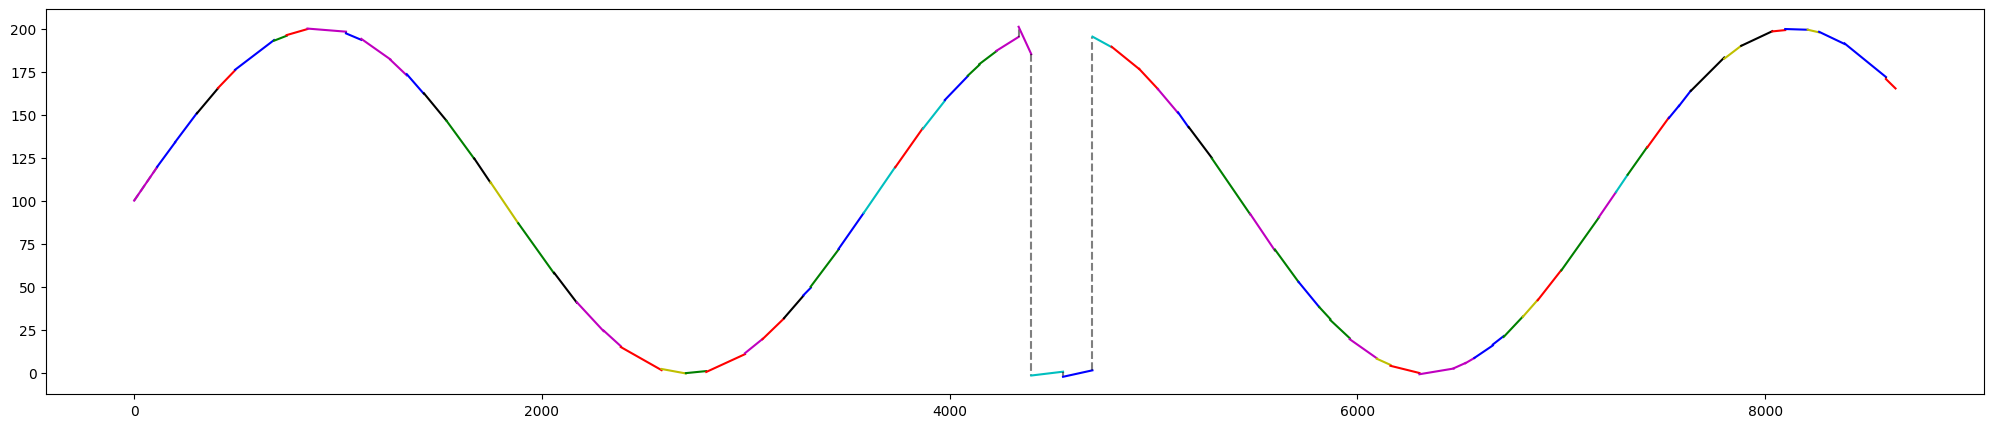

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.981944,1.0,0.48,0.648649


In [111]:
max_error = 98
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [94]:
anomaly_segment

(4229, 190.08767917169862, 4400, 193.9769430796116)

In [112]:
range_max_error_swab = (98,102)
best_swab = 100
time_avg_swab = (54.3+51.1+49.6)/3

# Conclusion

In [114]:
data = {
    'Id' : [6,6,6,6],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min(max_error)': [range_max_error_topdown[0],range_max_error_bottomup[0], range_max_error_sldw[0],range_max_error_swab[0]],
    'max(max_error)': [range_max_error_topdown[1],range_max_error_bottomup[1],range_max_error_sldw[1],range_max_error_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(in range)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [2,3,1,4]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min(max_error),max(max_error),Best,Time Average(in range),Accuracy,Precision,Recall,F1-score,Rank
0,6,Top-down,90000,5000000,2500000,22.733333,0.999884,0.996678,1.00,0.998336,2
1,6,Bottom-up,25000,35000,30000,5.470000,0.983333,1.000000,0.52,0.684211,3
2,6,Sliding-window,40000,1000000,75000,1.883333,1.000000,1.000000,1.00,1.000000,1
3,6,SWAB,98,102,100,51.666667,0.981944,1.000000,0.48,0.648649,4


# To exp

## Conclusion

In [115]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

## Feature _ Maxerror

In [116]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 6
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_max_error_topdown[0]
feature_max_error['Max(max_error)_Top_down'] = range_max_error_topdown[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_max_error_bottomup[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_max_error_bottomup[1]
feature_max_error['Min(max_error)_SLDW'] = range_max_error_sldw[0]
feature_max_error['Max(max_error)_SLDW'] = range_max_error_sldw[1]
feature_max_error['Min(max_error)_SWAB'] = range_max_error_swab[0]
feature_max_error['Max(max_error)_SWAB'] = range_max_error_swab[1]
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = best_swab

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [117]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,absolute_sum_of_changes,mean_abs_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,2,8640,102.151881,100.286884,212.017664,14.560826,95822.993645,11.091908,4.776042,62.598994,181.709748,50000,350000,30000,90000,35000,150000,30000,90000,60000
1,1,8640,104.621483,100.014344,442.227086,21.029196,4986.149682,0.577167,16.640276,98.129950,201.585487,50,850000,50,10100,10000,550000,50,12500,4975
2,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
3,4,8640,101.822061,101.317681,3.021211,1.738163,977.164373,0.113111,1.649976,99.734227,110.681462,1400,5000,0,100,400,1400,0,100,50
4,6,8640,104.766749,113.999449,5159.711223,71.831130,10003.014053,1.157890,-1.502673,-5.871039,202.953165,90000,5000000,25000,35000,40000,1000000,98,102,100
